In [12]:
import sagemaker
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sagemaker.pytorch import PyTorch
from sagemaker.tensorflow import TensorFlow
import os
from io import BytesIO

boto_session = boto3.Session(region_name='us-east-1')
sagemaker_session = sagemaker.Session(boto_session=boto_session)

role = "arn:aws:iam::211125439249:role/service-role/AmazonSageMaker-ExecutionRole-20250314T153928"
role_name = role.split('/')[-1]  # Extract just the role name from the ARN

# Attach AdministratorAccess policy to your existing role
iam_client = boto3.client('iam')
iam_client.attach_role_policy(
    RoleName=role_name,
    PolicyArn="arn:aws:iam::aws:policy/AdministratorAccess"
)
print(f"Attached AdministratorAccess policy to role: {role}")

# Assume blood.csv is in S3 already - if not, upload it first
input_data_s3_uri = "s3://blue-blood-data/final_df.csv"

bucket_name = "blue-blood-data"
region = 'us-east-1'
file_key = 'final_df.csv'




[03/31/25 19:29:45] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=620299;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=343948;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\botocore\credentials.py#1352\1352]8;;\

Attached AdministratorAccess policy to role: arn:aws:iam::211125439249:role/service-role/AmazonSageMaker-ExecutionRole-20250314T153928


In [5]:
# First, make sure train.py exists in the notebook directory
if not os.path.exists("train.py"):
    print("Error: train.py not found in the current directory")
else:
    print("Found train.py in the current directory")
    
    # Upload train.py to S3 to ensure latest version is used
    code_prefix = "code"
    s3_code_path = sagemaker_session.upload_data("train.py", bucket=bucket_name, key_prefix=code_prefix)
    print(f"Uploaded train.py to {s3_code_path}")

# Verify that the S3 data file exists
try:
    s3_client = boto3.client('s3', region_name=region)
    s3_client.head_object(Bucket=bucket_name, Key=file_key)
    print(f"Verified that s3://{bucket_name}/{file_key} exists")
except Exception as e:
    print(f"Warning: Error verifying S3 file: {e}")

Found train.py in the current directory
Uploaded train.py to s3://blue-blood-data/code/train.py
Verified that s3://blue-blood-data/final_df.csv exists


In [9]:
# Define parameters for initial test run
test_epochs = 10
test_learning_rate = 0.001
test_lstm_units = 64
test_dropout_rate = 0.2

# Create a unique job name for the test run
test_job_name = f"lstm-med-test-e{test_epochs}-lr{test_learning_rate}-u{test_lstm_units}-d{int(test_dropout_rate*10)}"
print(f"Starting test job: {test_job_name}")

# Create the TensorFlow estimator
estimator = TensorFlow(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',  # Using GPU instance
    framework_version='2.9',  # TensorFlow version
    py_version='py39',
    sagemaker_session=sagemaker_session,
    hyperparameters={
        'epochs': test_epochs,
        'learning_rate': test_learning_rate,
        'lstm_units': test_lstm_units,
        'dropout_rate': test_dropout_rate,
        'batch_size': 1
    },
    job_name=test_job_name
)

# Start training job
estimator.fit({'train': input_data_s3_uri})

# After training, you can deploy the model
# predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')


Starting test job: lstm-med-test-e10-lr0.001-u64-d2


[03/31/25 19:16:02] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=351618;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\telemetry\telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=738491;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\telemetry\telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=87831;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=692430;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

[03/31/25 19:16:03] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=52041;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=602890;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=280065;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=592519;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\session.py#1042\1042]8;;\
                             tensorflow-training-2025-04-01-00-16-02-765                                           

2025-04-01 00:16:01 Starting - Starting the training job...
2025-04-01 00:16:15 Starting - Preparing the instances for training...
2025-04-01 00:16:59 Downloading - Downloading the training image.........
2025-04-01 00:18:20 Training - Training image download completed. Training in progress.2025-04-01 00:18:25.674611: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2025-04-01 00:18:25.674796: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2025-04-01 00:18:25.700889: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2025-04-01 00:18:27,873 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2025-04-01 00:18:27,884 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-0

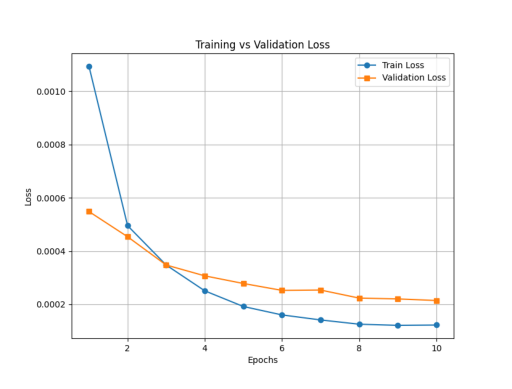

In [13]:
# Initialize the S3 client
s3 = boto3.client('s3')

# Define the bucket name and the file (graph) you want to fetch
s3_key = 'baseline_model/baseline-training-validation-loss.png'  # Adjust the path as needed

# Fetch the file from S3 into memory
response = s3.get_object(Bucket=bucket_name, Key=s3_key)
image_data = response['Body'].read()
image = BytesIO(image_data)

# Display the image using matplotlib
img = plt.imread(image)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()
